# The CIFAR-10 dataset
# https://www.cs.toronto.edu/~kriz/cifar.html
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each cla
sThese are the class names of the data set: airplane, automobile, bird, cat, deer, dog, frog, horse, ship,truck.

uck										

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includ

You can find some baseline replicable results on this dataset on the project page for cuda-convnet. These results were obtained with a convolutional neural network. Briefly, they are 18% test error without data augmentation and 11% with. Additionally, Jasper Snoek has a new paper in which he used Bayesian hyperparameter optimization to find nice settings of the weight decay and other hyperparameters, which allowed him to obtain a test error rate of 15% (without data augmentation) using the architecture of the net that got 18%.es pickup trucks. each:

In [5]:

#https://www.cs.toronto.edu/~kriz/cifar.html

# Imports

In [7]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
from keras_tuner import Hyperband


# Data Loading

In [9]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Data Splitting

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

# Visualization of Data

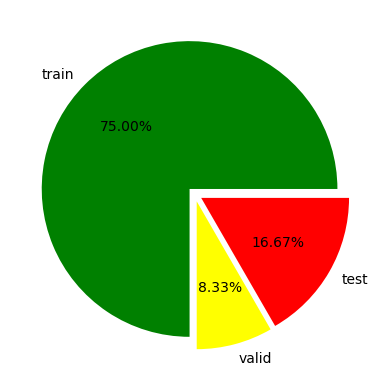

In [13]:
plt.pie([len(X_train),len(X_valid),len(X_test)],labels=["train","valid","test"],autopct="%.2f%%",colors=["green","yellow","red"],explode=(0.05,0.05, 0.05))
plt.show()

In [14]:
X_class=["Train","Valid","Test"]
X_data = [X_train, X_valid, X_test]
y_data = [y_train, y_valid, y_test]
for i in range(len(X_class)):
    print(f'{X_class[i]} Images Shape:', X_data[i].shape)
    print(f'{X_class[i]} Labels Shape:', y_data[i].shape)
    print("\t")

Train Images Shape: (45000, 32, 32, 3)
Train Labels Shape: (45000, 1)
	
Valid Images Shape: (5000, 32, 32, 3)
Valid Labels Shape: (5000, 1)
	
Test Images Shape: (10000, 32, 32, 3)
Test Labels Shape: (10000, 1)
	


In [15]:
class_names=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [16]:
y_train

array([[2],
       [9],
       [3],
       ...,
       [5],
       [4],
       [8]], dtype=uint8)

In [17]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (45000, 32, 32, 3)
y_train shape: (45000, 1)


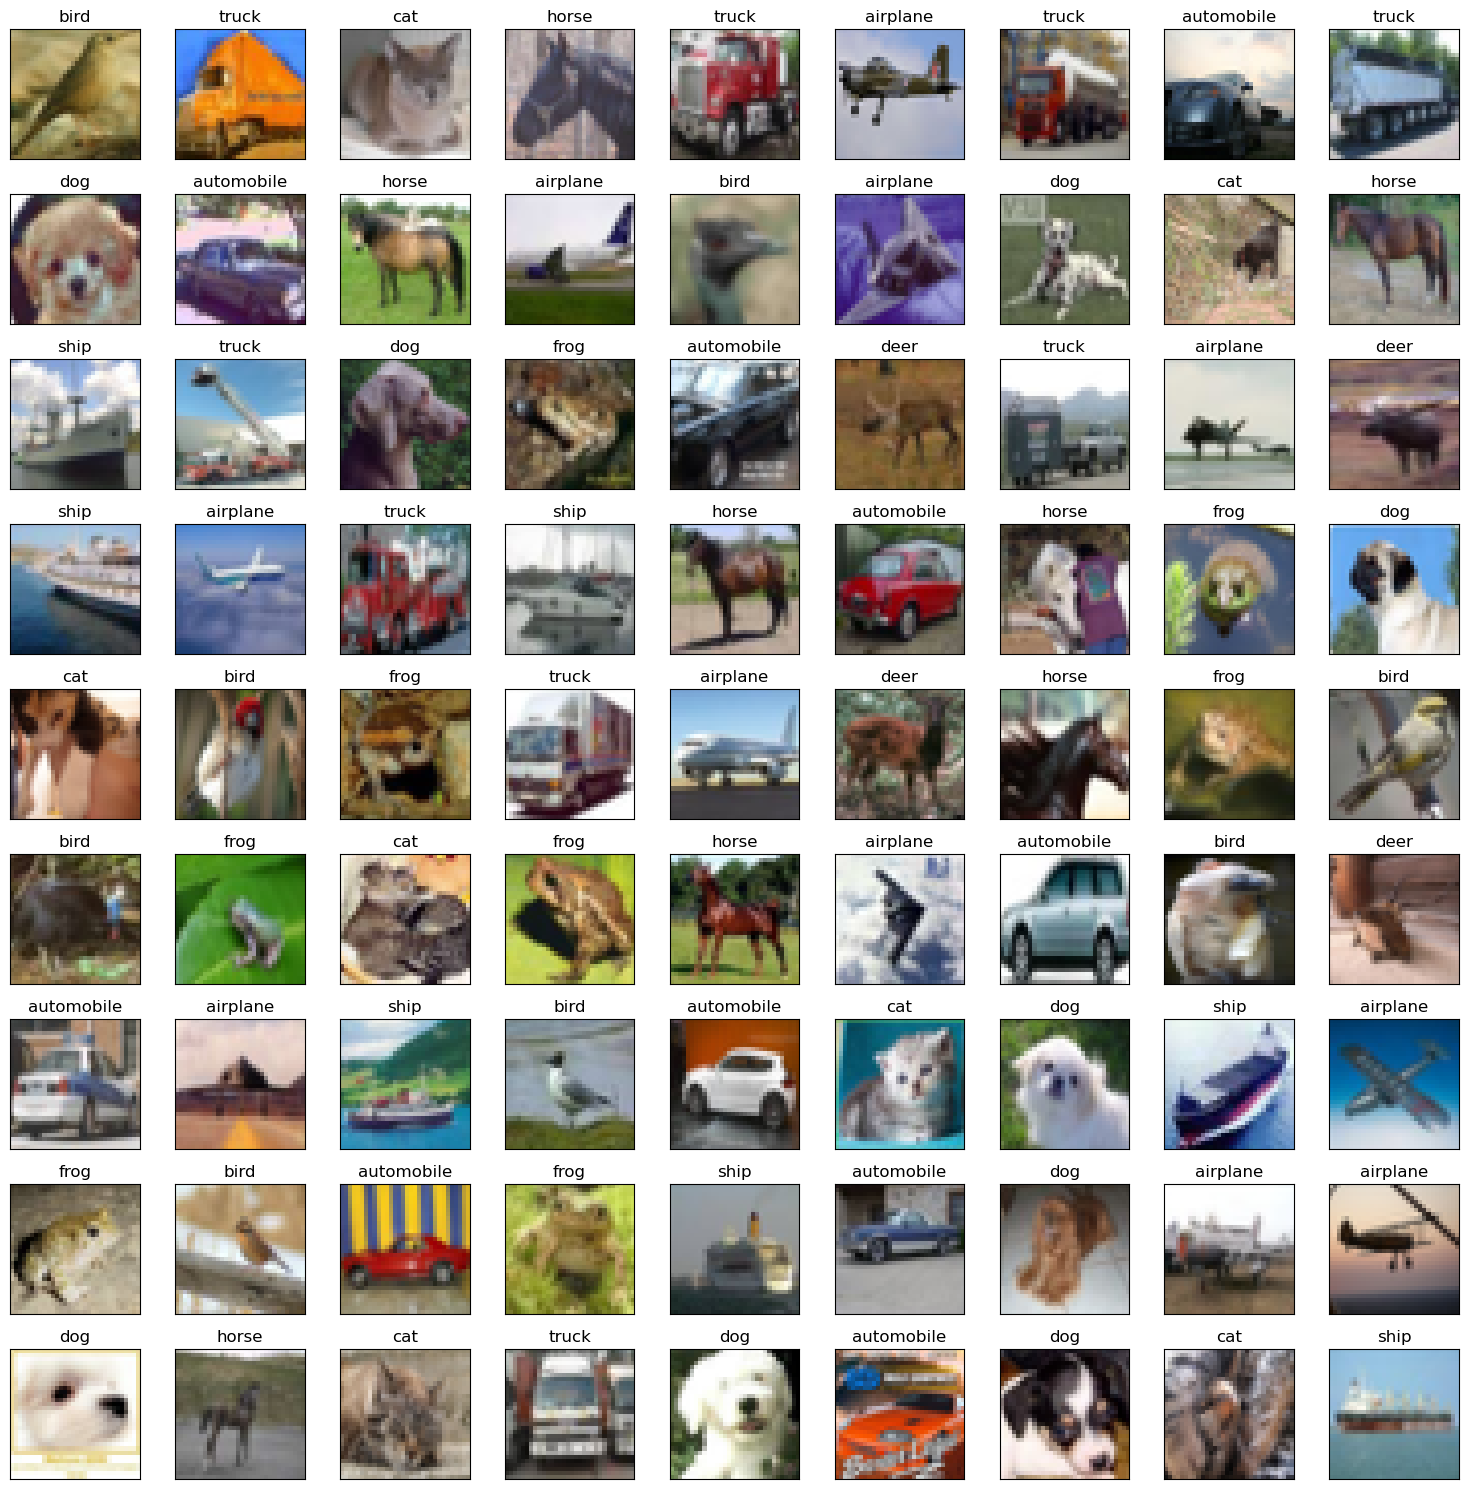

In [18]:
fix, axes = plt.subplots(9, 9, figsize=(15, 15))  
for i in range(81): 
    ax = axes[i // 9, i % 9]
    ax.imshow(X_train[i])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(class_names[y_train[i][0]], fontsize=12)
plt.tight_layout()  
plt.show()


In [19]:
train_classes, train_counts = np.unique(y_train, return_counts=True)
test_classes, test_counts = np.unique(y_test, return_counts=True)

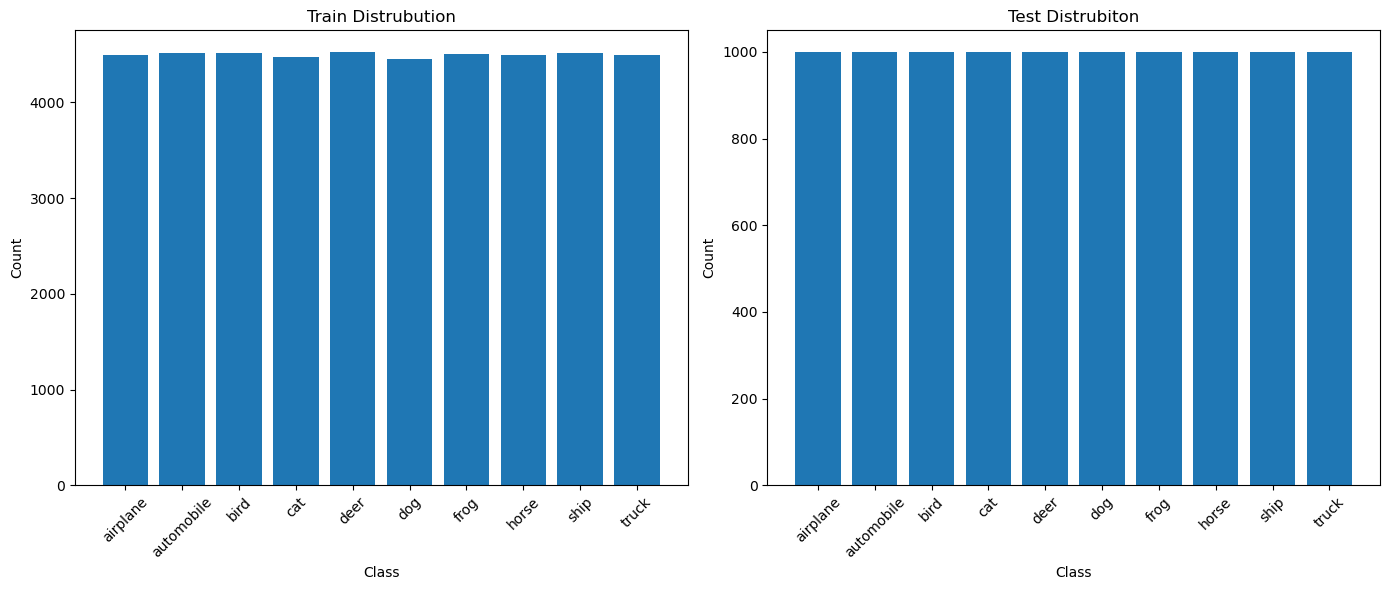

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(class_names, train_counts)
axes[0].set_title('Train Distrubution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(class_names, test_counts)
axes[1].set_title('Test Distrubiton')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)  

plt.tight_layout()
plt.show()

# Data preprocessing

Alternatif olarak float64 veya float16 gibi veri türleri kullanabilirdim. Ancak float64, float32'ye göre daha fazla hafıza tüketir ve çoğu derin öğrenme uygulaması için gereksiz bir hassasiyet sunar. float16 ise, belirli durumlarda daha hızlı işlem yapabilse de, yeterli doğruluk sağlamayabilir ve bu da modelin performansını olumsuz etkileyebilir. Dolayısıyla, float32, hem performansı artırmak hem de hafıza yönetimini optimize etmek için en uygun seçimdir.

In [23]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_valid = X_valid.astype('float32')

Alternatif yöntemler arasında min-max ölçekleme veya z-score standardizasyonu gibi teknikler bulunmaktadır. Ancak bu yöntemler, özellikle min-max ölçekleme, her veri kümesinin farklı dağılımlara sahip olabileceği durumlarda daha fazla dikkat gerektirebilir. Z-score standardizasyonu ise, verilerin ortalamasını ve standart sapmasını kullanarak ölçeklendirir, ancak bu da özellikle büyük veri setlerinde, hesaplama yükünü artırabilir.

Ayrıca, piksel değerlerinin 0 ile 255 arasında olduğu düşünüldüğünde, bu aralıkta bir normalizasyon işlemi uygulamak, modelin öğrenme sürecini daha öngörülebilir hale getirir. Sonuç olarak, 255'e bölme yöntemini seçmem, modelin verimliliğini artırırken hesaplama yükünü azaltmak ve daha iyi bir genelleme sağlamak içindir.

In [25]:
X_train = X_train/ 255
X_test = X_test/255
X_valid=X_valid/255

# ONE HOT ENCODİNG

Derin öğrenme modellerinin doğru çalışabilmesi için etiketlerin uygun bir formatta olması gereklidir. Yüksek düzeyde performans için, one-hot encoding (to_categorical) kullanmayı tercih ettim. Bu yöntem, her sınıfı bağımsız bir birim olarak temsil eder, bu sayede model sınıflar arasında karışıklığı önler ve daha iyi genelleme yapar.

Alternatif yöntemler, örneğin integer veya label encoding, sınıflar arasında bir sıralama izlenimi yaratabilir. Bu durum, modelin yanlış öğrenmesine yol açarak performansı düşürebilir. Categorical crossentropy kayıp fonksiyonu, one-hot encoded etiketlerle daha iyi çalışır; bu da modelin daha etkili öğrenmesini sağlar.

Kısacası, one-hot encoding kullanmak, modelimin doğruluğunu artırmak ve sınıflandırma sürecini optimize etmek için kritik bir adımdır.

In [27]:
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

In [28]:
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

# Data AugMantation
Data augmentation, modelinizin genelleme yeteneğini artırır ve overfitting'i önler. Bu, modelin performansını artırır.
Gerçek dünya verileri genellikle bozulmalara, değişikliklere veya gürültüye maruz kalabilir. Data augmentation, bu tür durumlara dayanıklı bir model geliştirilmesine yardımcı olur.
Model, daha fazla çeşitlilikle eğitildiğinde, daha iyi öğrenme ve sınıflandırma yetenekleri kazanır.
Alternatif yöntemler de değerlendirilebilir, ancak veri artırmanın sunduğu çeşitlilik ve esneklik, modelin genel başarısı için kritik öneme sahiptir.

In [30]:
def mixup(batch_x, batch_y):
    idx = np.random.choice(len(batch_x), size=2, replace=False)
    x1, x2 = batch_x[idx[0]], batch_x[idx[1]]
    y1, y2 = batch_y[idx[0]], batch_y[idx[1]]
    alpha = np.random.beta(0.2, 0.2)
    mixed_x = alpha * x1 + (1 - alpha) * x2
    mixed_y = alpha * y1 + (1 - alpha) * y2
    return mixed_x, mixed_y
def random_crop(image):
    crop_size = int(image.shape[0] * 0.9)  # %10 kes
    return image[:crop_size, :crop_size]

# Gürültü eklemek için fonksiyon
def add_random_noise(image):
    noise = np.random.normal(loc=0.0, scale=0.1, size=image.shape)  
    return np.clip(image + noise, 0, 1)

# Kontrast ayarlamak için fonksiyon
def random_contrast(image):
    factor = np.random.uniform(0.8, 1.2) 
    return np.clip(image * factor, 0, 1)

In [31]:
# Data augmentation
data_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    shear_range=10,
    channel_shift_range=0.1,
    preprocessing_function=add_random_noise
)


# Hyperparameter Tuning

Hiperparametre tuning, derin öğrenme modellerinin performansını artırmak için son derece önemlidir çünkü modelin öğrenme sürecindeki kritik ayarları optimize ederek daha iyi sonuçlar elde edilmesini sağlar. Alternatif hiperparametre yöntemleri olsa da, bu yöntemi tercih etmemin birkaç nedeni vardır. Öncelikle, hiperparametre tuning, modelin aşırı öğrenme (overfitting) ve yetersiz öğrenme (underfitting) gibi sorunlarını azaltarak, doğruluğu ve genelleme yeteneğini artırır. Örneğin, grid search gibi basit yöntemler belirli aralıklarla parametreleri test etse de, zaman ve kaynak verimliliği açısından sınırlı kalabilir. Bunun yerine, otomatikleştirilmiş hiperparametre tuning yöntemleri, birçok kombinasyonu hızlı ve etkili bir şekilde deneme imkanı sunar, böylece daha iyi sonuçlar elde etme olasılığını artırır.

Ayrıca, farklı veri setleri için en uygun hiperparametrelerin bulunmasını sağlar; bu da modelin genel performansını artırır. Hiperparametre tuning, yalnızca modelin mimarisini optimize etmekle kalmaz, aynı zamanda öğrenme oranı gibi kritik parametrelerin daha etkili bir şekilde ayarlanmasını mümkün kılar. Sonuç olarak, bu yöntem, derin öğrenme süreçlerinde esneklik ve verimlilik sunarak, en iyi sonuçları elde etmenin anahtarıdır. 

# Model 
Modelimi bu şekilde oluşturmamın nedeni, görüntü verileriyle çalışırken etkili bir sınıflandırma süreci sağlamaktır. Sequential model, katmanları ardışık bir sırada ekleyerek basit bir yapı oluşturmayı mümkün kılar; bu, bizim durumumuzda en mantıklısıdır çünkü tek bir girdi ve çıktı katmanına sahip lineer bir yapı gerekmektedir. Alternatif olarak, daha karmaşık yapılar sunan Functional API veya Model subclassing gibi yöntemler de mevcut, ancak bu projede daha basit bir modelle başlamanın ve hiyerarşiyi belirgin bir şekilde kurmanın faydalı olacağını düşündüm.

Görüntü verileri için Conv2D katmanları, uzamsal hiyerarşiyi yakalamak amacıyla yerel özellikleri öğrenmekte oldukça etkilidir; bu katmanlar, görüntüdeki önemli özellikleri tanımlamak için filtreler kullanır. Bunun yerine tamamen bağlantılı katmanlar (Dense) kullanmak, daha fazla hesaplama yükü ve daha az genel özellik öğrenme kapasitesi sunar. Ayrıca, görüntü verileri için bu tür katmanlar genellikle daha yüksek doğruluk sağlamakta yetersiz kalır.

BatchNormalization katmanı, aşırı öğrenmeyi (overfitting) önlemek ve öğrenme sürecini hızlandırmak için her bir mini-batch için katmanın çıktılarını normalize eder, bu da daha hızlı ve kararlı bir eğitim süreci sağlar.

MaxPooling2D, feature map boyutunu küçülterek modelin hesaplama yükünü azaltırken daha yüksek seviyede özelliklerin öğrenilmesine olanak tanır. Eğer subsampling kullanılmazsa, modelin hesaplama maliyeti önemli ölçüde artar ve aşırı öğrenme riski artar. Bu nedenle, MaxPooling katmanı, modelin verimli bir şekilde öğrenmesini sağlar.

Dropout katmanı, aşırı öğrenmeyi azaltmak için rastgele nöronların kapatılmasını sağlar ve bu sayede modelin genelleme yeteneğini artırır

Flatten katmanı, elde edilen 3B özellik haritalarını 1B vektörlere dönüştürerek, tam bağlantılı katmanların daha iyi çalışabilmesini sağlar. Eğer bu katman kullanılmazsa, modelin öğrenmesi gereken bilgi biçimi uygun olmayabilir.

Son olarak, modelin sınıflandırma yapabilmesi için kullanılan Softmax aktivasyonu, çoklu sınıf sınıflandırma problemlerinde sınıfların toplam olasılığının 1 olmasını sağlar. Bunun yerine sigmoid gibi alternatif bir aktivasyon fonksiyonu seçilseydi, modelin yalnızca iki sınıf için geçerli olabilirdi. Bu bağlamda, Softmax’ın çoklu sınıf problemleri için daha uygun olduğunu düşündüm.

Böylece, her katmanın özel bir rolü vardır ve bu yapı, modelin karmaşık bilgiler öğrenme kapasitesini artırırken aşırı öğrenme sorununu da minimize eder. Bu nedenle, modelimin tasarımı, görüntü verilerinin özelliklerini etkili bir şekilde öğrenebilmesi ve genel performansını artırması amacıyla bu şekilde oluşturulmuştur.


In [34]:
def build_model(hp):
    model = Sequential()
    weight_decay = hp.Float('weight_decay', min_value=1e-5, max_value=1e-3, sampling='LOG')

    # First katman
    model.add(Conv2D(filters=hp.Choice('filters_1', values=[32, 64]), kernel_size=(3,3), padding='same', 
                     activation='relu', kernel_regularizer=l2(weight_decay), input_shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    
    # Seond katman
    model.add(Conv2D(filters=hp.Choice('filters_1', values=[32, 64]), kernel_size=(3,3), padding='same', 
                     activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    # third and fourth layers
    model.add(Conv2D(filters=hp.Choice('filters_2', values=[64, 128]), kernel_size=(3,3), padding='same', 
                     activation='relu', kernel_regularizer=l2(weight_decay)))   
    model.add(BatchNormalization())
    model.add(Conv2D(filters=hp.Choice('filters_2', values=[64, 128]), kernel_size=(3,3), padding='same', 
                     activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    # fifth and sixth layers
    model.add(Conv2D(filters=hp.Choice('filters_3', values=[128, 256]), kernel_size=(3,3), padding='same', 
                     activation='relu', kernel_regularizer=l2(weight_decay))) 
    model.add(BatchNormalization())
    model.add(Conv2D(filters=hp.Choice('filters_3', values=[128, 256]), kernel_size=(3,3), padding='same', 
                     activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    # Flatten and Dense layer
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))

    # Optimization
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [35]:
tuner = Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=2,
    factor=3,
    directory="hyper_band_dir",
    project_name="cnn_hyperbande"
)

Reloading Tuner from hyper_band_dir\cnn_hyperbande\tuner0.json


In [ ]:
# Start hyperparameter search
tuner.search(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

In [50]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [52]:
best_hyperparameters

In [54]:
# best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
# best model
best_model = tuner.hypermodel.build(best_hyperparameters)

# ReduceLROnPlateau , EarlyStopping
ReduceLROnPlateau ve EarlyStopping, modelimin eğitim sürecinde performansını artırmak için kullandığım önemli yöntemlerdir. ReduceLROnPlateau, modelin öğrenme oranını otomatik olarak düşürerek, doğruluk veya kayıp değerleri iyileşmediğinde daha etkili bir öğrenme sağlar. Bu, modelin lokal minimumda kalmasını önleyerek eğitim sürecini verimli kılar. Sabit bir öğrenme oranı kullanmak zaman kaybına neden olabileceğinden, bu yöntemi tercih ettim. EarlyStopping ise modelin belirli bir süre boyunca iyileşme göstermediğinde eğitimini durdurarak aşırı öğrenmeyi önler. Bu sayede en iyi sonuç elde edildiğinde durarak zaman ve kaynak tasarrufu sağlar. Manuel ayarlamalar yerine bu yöntemleri seçerek daha etkili bir eğitim süreci sağlıyorum.

In [56]:
# Creating the ReduceLROnPlateau function 
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.2,         
    patience=20,         
    min_lr=1e-6,         
    verbose=1            
)

# Creating the EarlyStopping function  
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=20,         
    restore_best_weights=True, 
    verbose=1            # Bilgilendirme için
)

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Training the CNN Model

In [ ]:
# Training Model
history = best_model.fit(
    data_generator.flow(X_train, y_train, batch_size=32), 
    validation_data=(X_valid, y_valid),
    epochs=50, 
    callbacks=[reduce_lr, early_stopping],
    steps_per_epoch=len(X_train) // 32,
    verbose=2
)

# Evaluating

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=1)
print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

 Image 100 is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
The model predict that image 100 is 0


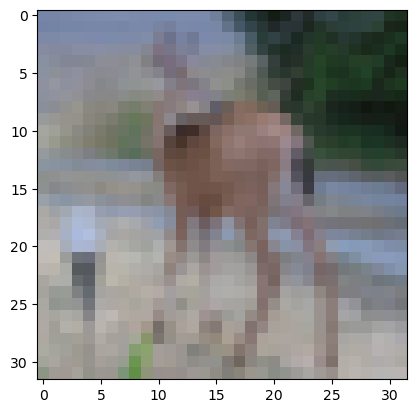

In [94]:
my_image = X_test[100]
plt.imshow(my_image)
print(f" Image 100 is {y_test[100]}")
predict = np.argmax(best_model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 100 is {predict}")

# Visualizing

In [ ]:

plt.figure(figsize=(12, 4))

#Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kaybı')
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def plotloss(history_2):
    plt.plot(history_2.history['loss'])
    plt.plot(history_2.history['val_loss'])
    plt.plot(history_2.history['accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation', 'Accuracy'])
    plt.show()    
plotloss(history)